# Kinetic Modeling with PYthon (kmpy)

In [1]:
import os, sys
import numpy as np
from constants import GAS_CONST, PR_ATM
from constants import KCAL_JL, HT_JL
import pandas as pd
import math
import re
from assimulo.solvers import CVode
from assimulo.problem import Explicit_Problem
import matplotlib.pyplot as plt

Could not find GLIMDA.


In [2]:
cwd = os.getcwd()

setting up the paths for the input files

In [209]:
def set_paths(myPath):
    """
    Set the absolute path to required files on the current machine.

    Returns
    -------
    reactionlist_path     : str
                            path to the file `complete_reactionlist.dat`
    rateconstantlist_path : str
                            path to the file `complete_rateconstantlist.dat`
    free_enenry_path      : str
                            path to the file `compositionlist.dat`
    """
    #myPath = os.path.dirname(os.path.abspath(__file__))
#     reactionlist_path = myPath + '/data/complete_reaction_list.dat'
#     rateconstantlist_path = myPath + '/data/complete_rateconstant_list.dat'
#     free_energy_path = myPath + '/data/free_energy_library.dat'
    reactionlist_path = myPath + '/../kmpy/tests/data/complete_reaction_list.dat'
    rateconstantlist_path = myPath + '/../kmpy/tests/data/complete_rateconstant_list.dat'
    free_energy_path = myPath + '/../kmpy/tests/data/free_energy_library.dat'
    return reactionlist_path, rateconstantlist_path, free_energy_path


In [210]:
file_reactionlist, file_rateconstantlist, file_free_energy = set_paths(cwd)

In [211]:
df_rate = pd.read_csv(file_rateconstantlist, header = None, sep = ' ')
df_rate.head()

,0,1,2
0,5.000000e+15,0,57.0
1,5.000000e+15,0,57.0
2,6.000000e+15,0,59.0
3,3.000000e+13,0,47.0


In [212]:
df_free_energy = pd.read_csv(file_free_energy, sep = '\t')
df_free_energy.head()

,Structure ID,smiles,electronic_energy,300K,400K,500K,600K,700K,800K
0,1,A,-572.654636,0.130831,0.114449,0.096034,0.075704,0.053580,0.029778
1,2,B,-76.422977,0.003836,-0.003547,-0.011258,-0.019238,-0.027448,-0.035861
2,3,C,-496.193201,0.103466,0.088156,0.071087,0.052368,0.032109,0.010414
3,4,D,-496.205201,0.104026,0.088926,0.072080,0.053591,0.033566,0.012107
4,5,E,-496.204142,0.104043,0.088886,0.071984,0.053439,0.033355,0.011835


In [213]:
class Reaction(object):
    
    
    def __init__(self):
        self.reactants_names = []
        self.products_names = []
        self.uniqueSpeciesList = []
        #species_names = []
        
   
    def getReactantsName(self, line):
        
        for spec in line.split(','):
            if float(spec.split('_')[0].split()[0]) < 0:
                self.reactants_names.append((spec.split('_')[0].split()[0],
                                          spec.split('_')[1].split()[0]))
            #print(self.species_names)
        return self.reactants_names
    
    def getProductsName(self, line):
        
        for spec in line.split(','):
            if float(spec.split('_')[0].split()[0]) > 0:
                self.products_names.append((spec.split('_')[0].split()[0],
                                          spec.split('_')[1].split()[0]))
            #print(self.species_names)
        return self.products_names
    
    def uniqueSpeciesName(self, line, species_list):
        #self.uniqueSpeciesList = species_list
        for spec in line.split(','):
            #self.uniqueSpeciesList = species_list
            # If the species has already been added to the list then move on.
            if spec.split('_')[1].split()[0] in species_list:
                self.uniqueSpeciesList = species_list
                continue
            else:
                #print(self.uniqueSpeciesList)
                self.uniqueSpeciesList = species_list
                self.uniqueSpeciesList.append(spec.split('_')[1].split()[0])
            #print(spec.split('_')[1].split()[0])
        return self.uniqueSpeciesList
    

In [214]:
def build_species_list(reaction_file):
    """
    Build reactnat and product list for each reaction. Also builds a list
    of unique species in the mechanism
    Parameters
    ----------
    reaction_file       : str
                           path to the file `complete_reaction_list.dat`
    Returns
    ----------
    reactant_list       : list
                         a list of the reactants and their stoichiometric
                         coeffs for each reaction
    product_list        : list
                         a list of the products and their stoichiometric
                         coeffs for each reaction
    species_list        : list
                        a list of unique species in the mechanism
    """

    #initializing reactant, product and unique species list
    reactant_list = []
    product_list = []
    species_name = []

    for line in open(reaction_file, 'r').readlines():
        reac = Reaction()
        reactant_list.append(reac.getReactantsName(line))
        product_list.append(reac.getProductsName(line))
        current_species = species_name
        #print(current_species)
        species_list = reac.uniqueSpeciesName(line, current_species)
        #print(species_name)
    species_list.sort()

    return reactant_list, product_list, species_list

reactants_list, products_list, unique_species = build_species_list(file_reactionlist)
    

In [215]:
print(unique_species)
print(len(unique_species))

['A', 'B', 'C', 'D', 'E', 'F']
6


In [216]:
#print(len(products_list))
print(products_list)

[[('1.0', 'B'), ('1.0', 'C')], [('1.0', 'B'), ('1.0', 'D')], [('1.0', 'B'), ('1.0', 'E')], [('1.0', 'F')]]


In [217]:
reac_prod_list = [react + prod for react, prod in zip(reactants_list, products_list)]
# for react, prod in zip(reactants, products):
#     total.append(react + prod)
#print(total)

In [218]:
print(reac_prod_list)

[[('-1.0', 'A'), ('1.0', 'B'), ('1.0', 'C')], [('-1.0', 'A'), ('1.0', 'B'), ('1.0', 'D')], [('-1.0', 'A'), ('1.0', 'B'), ('1.0', 'E')], [('-1.0', 'A'), ('1.0', 'F')]]


In [219]:
#generating a dictionary of unique species from the species_list
speciesindices = {unique_species[i]: i for i in range(0, len(unique_species))}

indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))

In [220]:
speciesindices
#indices_to_species

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [221]:
reac_matrix = np.zeros((len(reac_prod_list),len(unique_species)), dtype = float)
reac_matrix

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [222]:
for rxnindex, reac_list in enumerate(reac_prod_list):
    for x in range (len(reac_list)):
        species = reac_list[x][1]
        for i in range (len(unique_species)):
            if i == speciesindices[species]:
                reac_matrix[rxnindex][i] = float(reac_list[x][0])

print(reac_matrix.shape)
                

(4, 6)


Next, we need to build the rate constants for all the reactions. The forward rate constants can be calculated using Arrhenius equation

$k_f = A T^n exp (\frac{-E_a}{RT}) $

In [223]:
class Kinetic_params(object):
      
    def __init__(self):
        self.forward_rate_params = []
        self.forward_rates = []
        #self.forward_E = []
        #self.uniqueSpeciesList = []
        #species_names = []
    
    def getForwardRateParameters(self, line):
        
        self.forward_rate_params = [line.split(' ')[0], line.split(' ')[1],
                                    line.split(' ')[2].split()[0]]
      
        return self.forward_rate_params
    
    def getForwardRateConstant(self, parameters, T):
        
        self.forward_rates = (eval(parameters[0]) * T ** eval(parameters[1]) *
                             np.exp(- eval(parameters[2]) * KCAL_JL / (GAS_CONST * T)))
        return self.forward_rates

In [239]:

T = 573


In [240]:
def build_kmatrix_forward(rateconstantlist, temp):
    
    rate_constants = []
    for line in open(rateconstantlist, 'r').readlines():
        f_params = Kinetic_params()
        params = f_params.getForwardRateParameters(line)
        #print(params)
        rate_constants.append(f_params.getForwardRateConstant(params, temp))
    return rate_constants

In [241]:
forward_rate_constants = build_kmatrix_forward(file_rateconstantlist, T)
forward_rate_constants

[9.070586400466592e-07,
 9.070586400466592e-07,
 1.8791556907858517e-07,
 3.548590208923674e-05]

Next, to calculate the reverse rate constants, we need to calculate the thermodynamic equilibrium constants using the folloing equation

$ K_{eq} = exp (-{\Delta G}/ RT)$

since, we have free energy corrections for all the species at a few specific temperature, we need to calculate it for any given temperature using linear interpolation

In [242]:
def build_free_energy_dict(free_energy_path, temp):
    """
    Build a dictionary of free energy at a given temperature for all the species 
    present in the mechanism. It reads the file free_energy_path which is basically
    a library of gibbs free energy correction at different molecules at different temperatures.
    Parameters
    ----------
    completereactionlist : str
                           path to the file `free_energy_library.dat`
    T                    : float
                           temperature to calculate free energy
    Returns
    -------
    free_energy.    : dict
                    a dictionary where keys are unique species and values
                    are free energy of species at a given temperature 
                    build from free_energy_library.dat
    """
    
    df = pd.read_csv(free_energy_path, sep = '\t')

    if "{}K".format(temp) in df.columns:
        df["Free Energy @{}K".format(temp)] = df['electronic_energy'] + df["{}K".format(temp)]
    else:
        temp_low = math.floor(temp / 100.0)* 100
        temp_high = math.ceil(temp / 100.0)* 100
        df["{}K".format(temp)] = (df["{}K".format(temp_high)] - df["{}K".format(temp_low)])*(temp - temp_low)/(temp_high - temp_low) + df["{}K".format(temp_low)]
        df["Free Energy @{}K".format(temp)] = df['electronic_energy'] + df["{}K".format(temp)]
    #print(df.head())
    
    free_energy = dict([(i, a) for i, a  in zip(df.smiles, df["Free Energy @{}K".format(temp)])])
    
    return free_energy

In [243]:
free_energy_dict = build_free_energy_dict(file_free_energy, T)
#print(free_energy_dict)

In [244]:
def build_free_energy_change(complete_list, free_energy):
    """
    Calculate the reverse rate constants of all the reactions. There are two steps 
    doing this
    1. Calculate the change in free energy for each reaction
            delG = G(products) - G(reactanat)
    This is calculated from the complete lists of reactions and free_energy_dict
    2. Use delG to calculate the equlilibrium constant
            Keq = exp (- delG/Gas Const * Temp)
    3. Use the following equation to calculate the reverse rate constant
            Keq = Kf / Kr * (Gas Const * Temp / Pressure)^n
    where n = total number of product molecules - total number of reactant molecules
    ----------
    complete_list        : list
                           A list of all the reactions with reactant and 
                         product species and their stoichimetric coeffs
    free_energy          : dict
                          A dictionary of free energies of all the species
                          at a given temperature, obtained from 
                          build_free_energy_dict function
    forward_rate         : A list of forward rate constants for all the reactions
                         obtained from build_forward_reaction_rates
    T                    : float
                           temperature to calculate free energy
    Returns
    -------
     reverse_rates       : list
                         A list of reverse rate constants
    """
    
    
    mol_change = []
    gibbs_energy_list = []

    for i, item in enumerate (complete_list):
        n_reac = 0
        n_prod = 0
        reac_free_energy = 0
        prod_free_energy = 0
        for entry in item:
        
            if float(entry[0]) < 0:
                n_reac = n_reac + abs(float(entry[0]))
                reac_free_energy = abs(float(entry[0])) * free_energy[entry[1]] + reac_free_energy
            else:
                prod_free_energy = abs(float(entry[0])) * free_energy[entry[1]] + prod_free_energy
                n_prod = n_prod + abs(float(entry[0]))
        #print(n_reac)
        mol_change.append(n_prod - n_reac)
        gibbs_energy_list.append((prod_free_energy - reac_free_energy) * HT_JL)
    
    return gibbs_energy_list, mol_change
    

In [245]:
gibbs_energy, mol = build_free_energy_change(reac_prod_list, free_energy_dict)
gibbs_energy

[-6.293953619833474,
 -34.75227321973887,
 -32.32967185957523,
 15.652259565004215]

Now, after all these, we can calculate the thermodynamic equilibrium constants using the folloing equation

$ K_{eq} = exp (-\frac{\Delta G}{RT})$

In [246]:
equilibrium_constants = [np.exp(-n * 1000 /(GAS_CONST * T)) for n in gibbs_energy]
equilibrium_constants

[3.7478059392258545,
 1472.7506416232027,
 885.6804806791698,
 0.03741877593758052]

Finally, we can calculate the reverse rate constants using the following equaion


$ K_{eq} = \frac{k_f}{k_r} (\frac{1000RT}{P})^{\Delta n}$, ${\Delta n}$ = number of product molecules - number of reactant molecules

multiplied by 1000 to convert it from $ \frac{m^3}{mol*s}$ to $ \frac{L}{mol*s}$

In [247]:
def build_kmatrix_reverse(complete_list, free_energy,
                          forward_rates, temperature):
    
    gibbs_energy, change_mol = build_free_energy_change(complete_list,
                                                        free_energy)

    equilibrium_constants = [np.exp(-n * 1000/(GAS_CONST * temperature))
                             for n in gibbs_energy]

    reverse_rates = [(a / b) * (GAS_CONST * temperature * 1000 / PR_ATM) ** c
                     if c < 3 else 0 for (a, b, c) in
                     zip(forward_rates, equilibrium_constants, change_mol)]

    return reverse_rates

reverse_rate_constants = build_kmatrix_reverse(reac_prod_list, free_energy_dict, forward_rate_constants, T)
reverse_rate_constants

[1.1379057686786213e-05,
 2.8957040503698464e-08,
 9.975478106112853e-09,
 0.0009483448135351068]

In [69]:
def build_stoic_matrix(complete_list, species_list, species_indices):

    matrix = np.zeros((len(complete_list),len(species_list)), dtype = float)
    rate_final = []
    for rxnindex, reac_list in enumerate(complete_list):
        #rate = ''
        rate_f = 'kf[%s] ' %rxnindex
        rate_r = '- kr[%s]' %rxnindex
        concentration_f = ''
        concentration_r = ''
        for x in range (len(reac_list)):
            species = reac_list[x][1]
            for i in range (len(species_list)):
                if i == species_indices[species]:
                    matrix[rxnindex][i] = float(reac_list[x][0])
                    if float(reac_list[x][0]) < 0:
                        if abs(float(reac_list[x][0])) == 1:
                            concentration_f += '* y[%s] ' % i
                        else:    
                            concentration_f += '* y[%s] ** %s ' % (i, abs(float(reac_list[x][0])))
                    else:
                        if abs(float(reac_list[x][0])) == 1:
                            concentration_r += '* y[%s] ' % i
                        else:    
                            concentration_r += '* y[%s] ** %s ' % (i, float(reac_list[x][0]))
        
        rate = rate_f + concentration_f + rate_r + concentration_r  
        #print(rate)
        rate_final.append(rate)
    return matrix, rate_final

In [70]:
matrix, rate_reac = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
rate_reac[43]

'kf[43] * y[41] - kr[43]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8 '

In [97]:
def build_concentartion(counter, number):
    
#    concentration = ''
    if abs(float(number)) == 1:
        concentration = '* y[%s] ' % counter
    else:    
        concentration = '* y[%s] ** %s ' % (counter, abs(float(number)))
        
    return concentration

def build_rate(reac, spc_list, matrix, index, speciesindices):
    concentration_f = ''
    concentration_r = ''
    rate_f = 'kf[%s] ' %index
    rate_r = '- kr[%s]' %index
    for x in range (len(reac)):
        species = reac[x][1]
        for i in range (len(spc_list)):
            if i == speciesindices[species]:
                matrix[index][i] = float(reac[x][0])
                if float(reac[x][0]) < 0:
                    concentration_f += build_concentartion( i, reac[x][0])
                else:
                    concentration_r += build_concentartion( i, reac[x][0])
    
    rate_reac = rate_f + concentration_f + rate_r + concentration_r
    
    return rate_reac
            
        
         
def build_stoic_matrix(complete_list, species_list, species_indices):

    matrix = np.zeros((len(complete_list),len(species_list)), dtype = float)
    rate_final = []
    for rxnindex, reac_list in enumerate(complete_list):
        rate = build_rate(reac_list, species_list, matrix, rxnindex, species_indices)
        rate_final.append(rate)
    return matrix, rate_final

In [208]:
matrix, rate_reac = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
rate_reac[43]

'kf[43] * y[41] - kr[43]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8 '

In [186]:



def build_dydt_list(complete_list, species_list, species_indices, rev_rate = 'yes'):
    
    reac_matrix, rate_reac = build_stoic_matrix(complete_list, species_list, species_indices)
    dydt_expressions = []
    for species in species_list:
        rate_equation = 'dy[%i]/dt = ' % (species_indices[species])
        i = species_indices[species]
        for j in range (len(rate_reac)):
            if reac_matrix[j][i] > 0:
                if reac_matrix[j][i] == 1.0:
                    if rev_rate == 'yes':
                        rate_equation += '+ %s' %(rate_reac[j])
                    else:
                        rate_equation += '+ %s' %(re.split('-', rate_reac[j])[0])
                else:
                    rate_equation += '+ %1.2f * %s' %(reac_matrix[j][i], re.split('-', rate_reac[j])[0])
                    if rev_rate == 'yes':
                        rate_equation += '- %1.2f * %s' %(reac_matrix[j][i], re.split('-', rate_reac[j])[1])
                    else:
                        pass
            elif reac_matrix[j][i] < 0:
                if reac_matrix[j][i] == -1.:
                    rate_equation += '- %s' %(re.split('-', rate_reac[j])[0])
                    if rev_rate == 'yes':
                        rate_equation += '+ %s' %(re.split('-', rate_reac[j])[1])
                    else:
                        pass
                else:
                    rate_equation += '- %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[0])
                    if rev_rate == 'yes':
                        rate_equation += '+ %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[1])
                    else: 
                        pass
            else:
                pass
        dydt_expressions.append(rate_equation)
    
    return dydt_expressions
        
#     rate_formation = 'd[%s]/dt = ' % (species)
#     # "entry" is [reaction#, sign of that reaction, coefficient]
#     for entry in species_rxns[species]:
#         if human == 'no':
#             rate_formation += '%s*%s' % \
#             (entry[2], rates_forward[entry[0]].split(' = ')[1])
#             rate_formation += '%s*%s' % \
#             (entry[3], rates_reverse[entry[0]].split(' = ')[1])
#         elif human == 'yes':
#             rate_formation += '%s*rate_f[%s] ' % (entry[2], entry[0])
#             rate_formation += '%s*rate_r[%s] ' % (entry[3], entry[0])
#         else:
#             raise ValueError('human must be a string: yes or no')
#     dydt_expressions.append(rate_formation)



In [187]:
dydt_list = []
dydt_list = build_dydt_list(reac_prod_list, unique_species, speciesindices, rev_rate = 'yes')
dydt_list[43]

'dy[43]/dt = - kf[0] * y[43] +  kr[0]* y[11] * y[40] - kf[1] * y[43] +  kr[1]* y[11] * y[41] - kf[2] * y[43] +  kr[2]* y[11] * y[42] - kf[3] * y[43] +  kr[3]* y[31] '

In [205]:
def build_eqn_forward(matrix, reaction_rate, rev_rate):
    if matrix > 0:
        sign1 = ' + '
        sign2 = ' - '
    else:
        sign1 = ' - '
        sign2 = ' + '
        
    if abs(matrix) == 1.0:
        rate = sign1 +'%s' %re.split('-', reaction_rate)[0]
        if rev_rate == 'yes':
            rate += sign2 +'%s' %re.split('-', reaction_rate)[1]
        else:
            pass
    else:
        rate = sign1 + '%1.2f * %s' %(matrix, re.split('-', reaction_rate)[0])
        if rev_rate == 'yes':
            rate += sign2 + '%1.2f *%s' %(matrix, re.split('-', reaction_rate)[1])
            
        else:
            pass
# print(rate)
    return rate




def build_dydt_list(complete_list, species_list, species_indices, rev_rate = 'yes'):
    
    reac_matrix, rate_reac = build_stoic_matrix(complete_list, species_list, species_indices)
    dydt_expressions = []
    for species in species_list:
        rate_equation = 'dy[%i]/dt = ' % (species_indices[species])
        i = species_indices[species]
        for j in range (len(rate_reac)):
            if abs(reac_matrix[j][i]) > 0:
                rate_equation += build_eqn_forward(reac_matrix[j][i], rate_reac[j], rev_rate)
#            elif reac_matrix[j][i] < 0:
#                 if reac_matrix[j][i] == -1.:
#                     rate_equation += '- %s' %(re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %s' %(re.split('-', rate_reac[j])[1])
#                     else:
#                         pass
#                 else:
#                     rate_equation += '- %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[0])
#                     if rev_rate == 'yes':
#                         rate_equation += '+ %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_reac[j])[1])
#                     else: 
#                         pass
#                rate_equation += build_eqn_forward(reac_matrix[j][i], rate_reac[j], rev_rate)
            else:
                pass

        dydt_expressions.append(rate_equation)
    
    return dydt_expressions

In [207]:
dydt_list = []
dydt_list = build_dydt_list(reac_prod_list, unique_species, speciesindices, rev_rate = 'yes')
dydt_list[1]

'dy[1]/dt =  + 3.90 * kf[42] * y[40]  - 3.90 * kr[42]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[43] * y[41]  - 3.90 * kr[43]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[44] * y[32]  - 3.90 * kr[44]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[45] * y[33]  - 3.90 * kr[45]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[46] * y[33]  - 3.90 * kr[46]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[47] * y[36]  - 3.90 * kr[47]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[48] * y[3]  - 3.90 * kr[48]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[49] * y[9]  - 3.90 * kr[49]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] ** 0.4 * y[11] ** 2.2 * y[45] ** 1.8  + 3.90 * kf[50] * y[25]  - 3.90 * kr[50]* y[1] ** 3.9 * y[0] ** 0.7 * y[44] *

In [164]:
a='kf(0) * y[0]**1.0 - kr(0)* y[1]**1.0 * y[2]**2.0'
import re
print(re.split('-', a))

['kf(0) * y[0]**1.0 ', ' kr(0)* y[1]**1.0 * y[2]**2.0']


In [36]:
stoic_matrix = np.zeros((len(reac_prod_list),len(unique_species)), dtype = float)
for rxnindex, reac_list in enumerate(reac_prod_list):
    for x in range (len(reac_list)):
        species = reac_list[x][1]
        for i in range (len(unique_species)):
            if i == speciesindices[species]:
                stoic_matrix[rxnindex][i] = float(reac_list[x][0])

#print(stoic_matrix[61])

In [37]:
reac_matrix = abs(stoic_matrix.clip(-20,0))
print(reac_matrix)
prod_matrix = stoic_matrix.clip(0,100)
# prod_matrix = stoic_matrix
# reac_matrix[reac_matrix > 0] = 0
# print(abs(reac_matrix))

# prod_matrix[prod_matrix < 0] = 0
#print(prod_matrix)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [38]:
b = np.array(([1, 4, 5], [3, 0,9]), dtype = int)
#print(b)
c = np.power([1,0,3], b)
#print(c)
c = np.where(b != 0, c, 0)
print(c)



[[    1     0   243]
 [    1     0 19683]]


In [39]:
import pylab as P
#import nose
from assimulo.solvers import CVode
from assimulo.problem import Explicit_Problem

In [41]:
kf = forward_rate_constants
#kf = [9.070586400466592e-07 , 9.070586400466592e-07 , 9.070586400466592e-07, 9.070586400466592e-07]
#kf = [1.0, 1.0, 1.0, 1.0]
kr = reverse_rate_constants
#kr = np.zeros(len(dydt_expressions))
def run_example(species_list, species_indices, dydt_list, with_plots=True):
    r"""
    Demonstration of the use of CVode by solving the
    linear test equation :math:`\dot y = - y`
    
    on return:
    
       - :dfn:`exp_mod`    problem instance
    
       - :dfn:`exp_sim`    solver instance
       
    """

    y0 = np.zeros((len(species_list)), dtype = float)
    y0[species_indices['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']] = 1
    #y0[0] = 0
    dydt = np.zeros((len(species_list)), dtype = float)
    #Define the rhs
    y = y0

    def rhs(t, C):
        y = C   
        
        for i in range (len(dydt_list)):
            dydt[i] = eval(dydt_list[i].split('=')[1])
        return dydt
#        return N.array([ydot])
#         Ca, Cb, Cc = C
#         dCadt = -k1 * Ca + k_1 * Cb
#         dCbdt = k1 * Ca - k2 * Cb - k_1 * Cb + k_2 * Cc
#         dCcdt = k2 * Cb - k_2 * Cc
#         return [dCadt, dCbdt, dCcdt]  
    

#    print(ode(0, y0))
    
    t0 = 0
    #Define an Assimulo problem
    exp_mod = Explicit_Problem(rhs, y0, t0, name = r'CVode Test Example: A --> B --> C')
    
    #Define an explicit solver
    exp_sim = CVode(exp_mod) #Create a CVode solver
    
    #Sets the parameters
    exp_sim.iter  = 'Newton' #Default 'FixedPoint'
    exp_sim.discr = 'Adams' #Default 'Adams'
    exp_sim.atol = [1e-5] #Default 1e-6
    exp_sim.rtol = 1e-5 #Default 1e-6
    exp_sim.maxh = 0.1
    exp_sim.display_progress = True
    #Simulate
    t1, y1 = exp_sim.simulate(10) #Simulate 5 seconds
#    t2, y2 = exp_sim.simulate(17) #Simulate 2 seconds more
  
    #Basic test
    #nose.tools.assert_almost_equal(float(y2[-1]), 0.00347746, 5)
    #nose.tools.assert_almost_equal(exp_sim.get_last_step(), 0.0222169642893, 3)
    
    #Plot
    if with_plots:
        P.plot(t1, y1, color="b")
        #P.plot(t2, y2, color="r")
        P.title(exp_mod.name)
        P.ylabel('y')
        P.xlabel('Time')
        P.show()
    #return exp_mod, exp_sim
    return t1, y1

In [42]:
# import io
# import sys

# text_trap = io.StringIO()
# sys.stdout = text_trap

mod, sim = run_example(unique_species, speciesindices, dydt_list, with_plots=False)

# sys.stdout = sys.__stdout__

Final Run Statistics: CVode Test Example: A --> B --> C 

 Number of steps                                 : 138
 Number of function evaluations                  : 152
 Number of Jacobian evaluations                  : 3
 Number of function eval. due to Jacobian eval.  : 138
 Number of error test failures                   : 1
 Number of nonlinear iterations                  : 148
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : Adams
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 12
 Tolerances (absolute)    : 1e-05
 Tolerances (relative)    : 1e-05

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 1.1986803870004223 seconds.


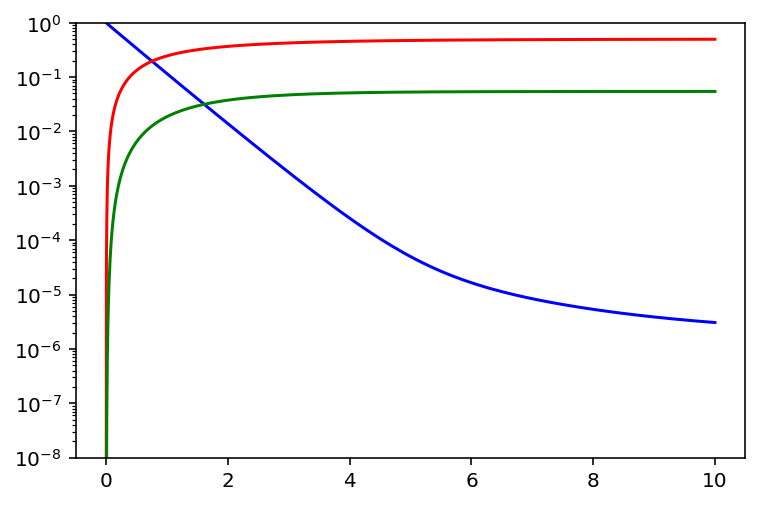

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(mod, sim[:,43], color="b")
plt.plot(mod, sim[:,speciesindices['O=CCO']], color="r")
plt.plot(mod, sim[:,speciesindices['O=Cc1ccco1']], color="g")
#P.xscale(10e-10)
plt.ylim(10e-9, 1)
plt.yscale('log')

Final Run Statistics: CVode Test Example: A --> B --> C 

 Number of steps                                 : 102
 Number of function evaluations                  : 107
 Number of Jacobian evaluations                  : 2
 Number of function eval. due to Jacobian eval.  : 92
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 103
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : Adams
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 12
 Tolerances (absolute)    : 1e-05
 Tolerances (relative)    : 1e-05

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.9204378539998288 seconds.
Final Run Statistics: CVode Test Example: A --> B --> C 

 Number of steps                                 : 107
 Number of function evaluations                  : 115
 Number of Jacobian evaluations            

Text(0, 0.5, 'Concentration')

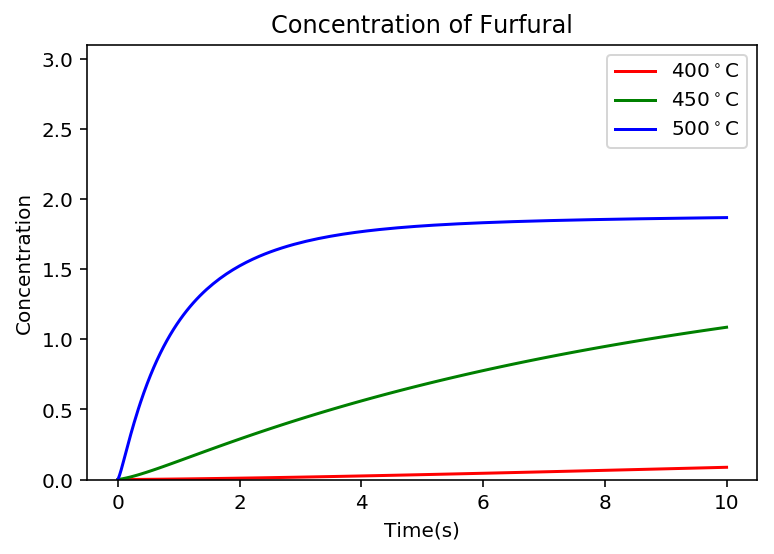

In [138]:
temperature = [673, 723, 773]

for i, T in enumerate(temperature):
    kf = build_kmatrix_forward(file_rateconstantlist, T)
    free_energy_dict = build_free_energy_dict(file_free_energy, T)
    kr = build_kmatrix_reverse(reac_prod_list, free_energy_dict, kf, T )
    colors = ['r', 'g', 'b']
    labels = ['400$^\circ$C', '450$^\circ$C', '500$^\circ$C']
    
#     text_trap = io.StringIO()
#     sys.stdout = text_trap
    
    mod, sim = run_example(unique_species, speciesindices, dydt_list, with_plots=False)
#     sys.stdout = sys.__stdout__
    
    plt.plot(mod, sim[:,speciesindices['O']], color = colors[i], label = labels[i])
#    plt.plot(mod, sim[:,43], color = colors[i], label = labels[i])
    plt.title('Concentration of Furfural')
    plt.ylim(10e-9, 3.1)
#    plt.yscale('log')
    plt.legend()
    
plt.xlabel('Time(s)')
plt.ylabel('Concentration')

In [ ]:
mod, sim = run_example(with_plots=False)
print(len(mod))

In [ ]:
print(mod)
print(sim[:, 43])
#P.plot(mod, sim, color="b")

In [ ]:
from assimulo.solvers.sundials import CVode #Imports the solver CVode from Assimulo
from assimulo.problem import Explicit_Problem #Imports the problem formulation from Assimulo   

def run_example():

    def rhs(t,y):
        A =np.array([[0,1],[-2,-1]])
        yd=np.dot(A,y)
        
        return yd
        
    y0=np.array([1.0,1.0])
    t0=0.0
        
    model = Explicit_Problem(rhs,y0,t0) #Create an Assimulo problem
    model.name = 'Linear Test ODE'

    sim = CVode(model) #Create the solver CVode

    tfinal = 10.0 #Specify the final time
        
    t,y = sim.simulate(tfinal) #Use the .simulate method to simulate and provide the final time
        
    #Plot
    P.plot(t,y)
    P.show()

if __name__=='__main__':
    run_example()